In [ ]:
!pip install -U datasets transformers accelerate bitsandbytes trl peft evaluate codebleu[all]
from datasets import load_dataset
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer,AutoModelForCausalLM,BitsAndBytesConfig,TrainingArguments,DataCollatorWithPadding
from peft import LoraConfig, PeftModel,prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
from transformers import pipeline
from datasets import Dataset
from codebleu import calc_codebleu

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# **FINE TUNING Llama2 with coding examples for coding assistantce**


This can achevied in following steps:

1.DOWNLOAD hugging face format llama2 model from Hugging face and tokenizer into colab

2.Preprocess the data to training format

3.Load model into RAM by quantizing using bitsandbytes and configure the LORA parameters

4.Finetune the model using LORA technique from peft with sfttrainer



# **PREPROCESING THE DATA**

In [3]:
df_o=pd.read_csv("/content/python_code_dataset.csv")
df=df_o[0:10000]
df.sample(5)

,instruction,input,output,prompt
2086,Develop a web-scraper in Python to retrieve in...,URL = https://en.wikipedia.org/wiki/Python_(pr...,import requests\nfrom bs4 import BeautifulSoup...,Below is an instruction that describes a task....
6956,Write a Python script to generate random numbe...,NaN,def genRandomFive():\n n = 100\n divisor...,Below is an instruction that describes a task....
128,Write a Python program to divide a given list ...,"[2, 3, 4, 5, 6, 7]",def divide_in_two_equal_parts(lst):\n targe...,Below is an instruction that describes a task....
3762,Create a function in Python to count the numbe...,NaN,"def CountLetterOccurrences(str, letter): \n ...",Below is an instruction that describes a task....
1232,Create a function in Python to remove all non-...,Not applicable,import re\n\ndef remove_non_alphanum(str):\n r...,Below is an instruction that describes a task....


In [4]:
llama_n="meta-llama/Llama-2-7b-hf"

finetuned_n="finetuned/Llama-2-7b-hf-finetuned-code"

In [16]:
dataset=Dataset.from_pandas(df)

tokenizer=AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

def format_prompt(sample):
    system_prompt="you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request "
    instruction=sample['instruction']
    input=sample["input"]
    answer=sample["output"]
    prompt=f"<s>[INST]<<SYS>> {system_prompt}<</SYS>>Instruction:{instruction}\n Input:{input}[/INST]\n {answer}</s>"
    sample['prompt']=prompt
    return sample

dataset=dataset.map(format_prompt)
dataset=dataset.remove_columns(['instruction', 'input', 'output'])
dataset=dataset.shuffle()

dataset_split = dataset.train_test_split(test_size=0.01)
train_data = dataset_split["train"]
validation_data = dataset_split["test"]


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
def tokens_len(sample):
    sample["prompt"]=len(tokenizer(sample['prompt'])["input_ids"])
    return sample

dataset_tok=dataset.map(tokens_len)
df_dataset=dataset_tok.to_pandas()

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

           prompt
count  10000.0000
mean     246.2996
std      359.3209
min       71.0000
25%      137.7500
50%      179.0000
75%      244.0000
max     5714.0000


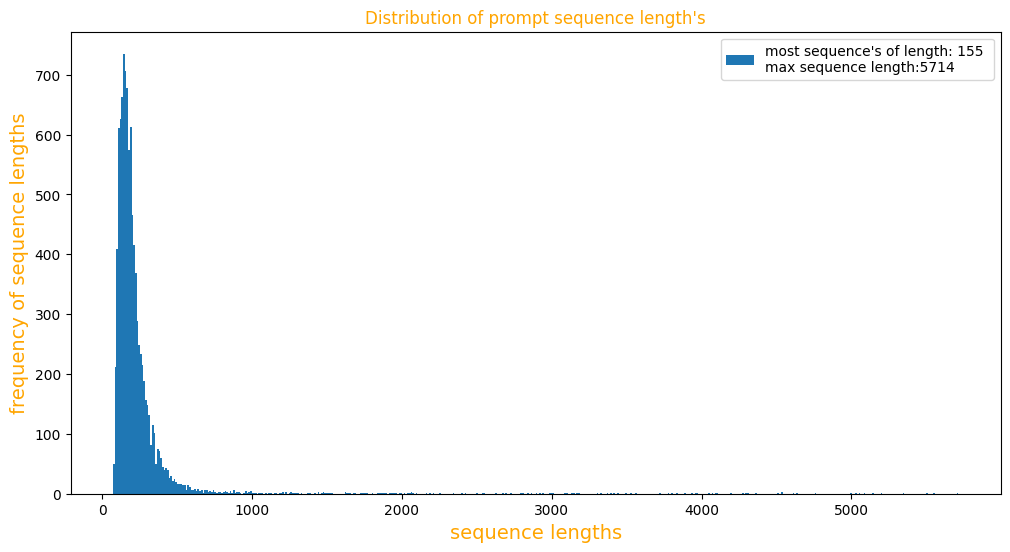

In [7]:
import matplotlib.pyplot as plt
print(df_dataset.describe())
fig,axis = plt.subplots(1,1,figsize=(12,6))
axis.hist(df_dataset["prompt"],bins=500)
axis.set_title("Distribution of prompt sequence length's",c="orange")
axis.set_xlabel("sequence lengths", fontsize=14, c="orange")
axis.set_ylabel("frequency of sequence lengths", fontsize=14,c="orange")
axis.legend(["most sequence's of length: {s} \nmax sequence length:{s1}".format(s=df_dataset["prompt"].mode()[0],s1=df_dataset["prompt"].max())], loc="upper right")
plt.show()

# **Load model by quantizing**

In [8]:
bnb_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=False
    )

model=AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf",quantization_config=bnb_config,device_map="auto")


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [9]:
print(model) # details of the quantized llama model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [10]:
print(df['prompt'][1253])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Design a class in Python to represent a Rectangle, which has the two attributes 'length' and 'width'.

### Input:


### Output:
class Rectangle:
  def __init__(self, length, width):
    self.length = length
    self.width = width


 **Since it is a base model which is not trained upon code datasets it will** **hallucinate which can be seen below with the above example**

In [ ]:
prompt="Design a class in Python to represent a Rectangle, which has the two attributes 'length' and 'width."

code_pipe=pipeline(task="text-generation",model=model,tokenizer=tokenizer,max_length=512,truncation=True)
print(code_pipe(prompt)[0]['generated_text'])

Design a class in Python to represent a Rectangle, which has the two attributes 'length' and 'width. kwieta 2020. 2020-04-14. The program is a basic implementation of a 2D grid game where the user can place tiles and move them around. The program is a basic implementation of a 2D grid game where the user can place tiles and move them around. I have a 2D array that is 10x10 and I need to calculate the sum of all the numbers in the array. In this post, I will show you how to write a 2D array in C#. A 2D array is a data structure that consists of a two-dimensional grid of elements. In this article, we will learn about 2D Array in Python. The array is stored in a two-dimensional matrix. I have a 2D array that is 10x10 and I need to calculate the sum of all the numbers in the array. In this article, we will learn about 2D Array in Python. A 2D array is a data structure that consists of a two-dimensional grid of elements. In this article, we will learn about 2D Array in Python. The array is 

# **Configuring the LORA model**

In [11]:
lora_config=LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj","down_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = prepare_model_for_kbit_training(model)

model_p = get_peft_model(model, lora_config)

model_p.config.use_cache = False
model_p.config.pretraining_tp = 1

trainable, total = model_p.get_nb_trainable_parameters()
print(f"Trainable: {trainable} | total: {total} | Percentage: {trainable/total*100:.2f}%")
print(f'Memory used by model: {round(model_p.get_memory_footprint()/2**30, 2)} GB')

Trainable: 9994240 | total: 6748409856 | Percentage: 0.15%
Memory used by model: 4.03 GB


In [12]:
print(model_p) #details of the QLORA model of llama

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit

# **Preparing the model for training**

In [23]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side="right"
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=False)

training_arguments = TrainingArguments(
    output_dir="/content/output",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=32,
    gradient_checkpointing = True,
    optim="paged_adamw_32bit",
    save_steps=15,
    eval_steps=1,
    logging_steps=1,
    learning_rate=2e-3,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=1,
    warmup_ratio=0.03,
    evaluation_strategy="steps",
    group_by_length=True,
    lr_scheduler_type="cosine"

)


trainer = SFTTrainer(
    model=model_p,
    train_dataset=train_data,
    eval_dataset=validation_data,
    dataset_text_field="prompt",
    max_seq_length=512,
    args=training_arguments,
    tokenizer=tokenizer,
    data_collator=data_collator,
    packing=True

)


trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, packing. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1961: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1,1.359700,1.453172
2,1.385000,1.349948
3,1.203900,1.153739
4,0.936900,1.054923
5,0.853200,1.067386
6,0.862700,1.089272
7,0.880300,1.058998
8,0.820300,1.042345
9,0.816300,1.018803
10,0.782400,1.007425


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=18, training_loss=0.872728963692983, metrics={'train_runtime': 13282.0165, 'train_samples_per_second': 0.359, 'train_steps_per_second': 0.001, 'total_flos': 9.367355240585626e+16, 'train_loss': 0.872728963692983, 'epoch': 0.9664429530201343})

In [24]:
trainer.model.save_pretrained(finetuned_n)

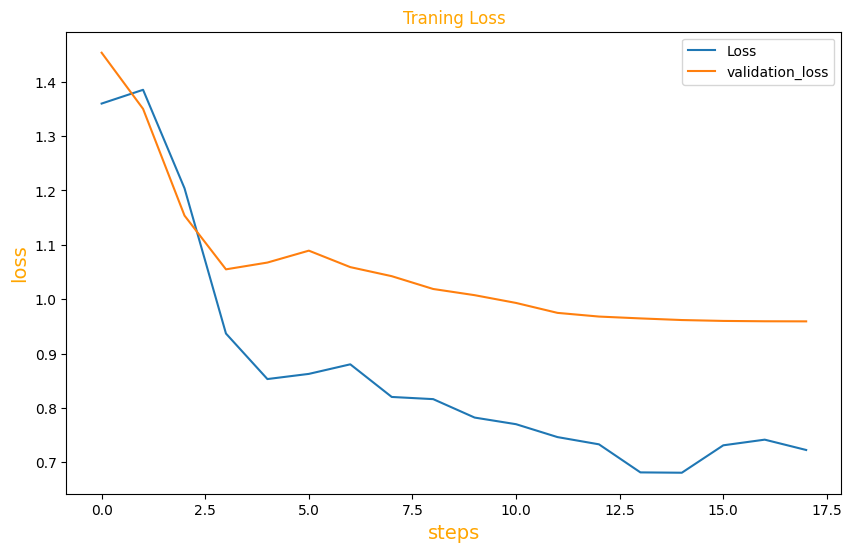

In [27]:
import matplotlib.pyplot as plt
loss=pd.DataFrame(trainer.state.log_history[0::2])
val_loss=pd.DataFrame(trainer.state.log_history[1::2])
history=pd.concat([loss,val_loss],axis=1)
history=history[['loss','eval_loss']]

fig,axis = plt.subplots(1,1,figsize=(10,6))
axis.plot(history)
axis.set_title("Traning Loss",c="orange")
axis.set_xlabel("steps", fontsize=14, c="orange")
axis.set_ylabel("loss", fontsize=14,c="orange")
axis.legend(["Loss","validation_loss"], loc="best")
plt.show()


# **Checking the Finetuned Model**

In [136]:
def inference(prompt):
    device = "cuda:0"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model_p.generate(**inputs, max_new_tokens=512)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [108]:
def format_val_prompt(sample):
    system_prompt="you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request "
    instruction=sample['instruction']
    input=sample["input"]
    answer=sample["output"]
    prompt=f"<s>[INST]<<SYS>> {system_prompt}<</SYS>>Instruction:{instruction}\n Input:{input}[/INST]\n answer: </s>"
    output=f"<s>[INST]<<SYS>> {system_prompt}<</SYS>>Instruction:{instruction}\n Input:{input}[/INST]\n answer:{answer}</s>"
    sample['prompt']=prompt
    sample["output"]=output
    return sample

def strip_answer(x):
    x["output"]=x["output"].split("[/INST]\n")[1]
    x["prediction"]=x["prediction"].split("[/INST]\n")[1]
    return x

def codeBLEU_evaluation(data_set):
    data_set["prediction"]=data_set["prompt"].apply(lambda x: inference(x))
    data_set=data_set.apply(lambda x: strip_answer(x),axis=1)
    result = calc_codebleu(references=data_set["output"].values.tolist(),predictions=data_set["prediction"].values.tolist(),lang="python", weights=(0.1, 0.1, 0.4, 0.4), tokenizer=None)
    return result


validation=df_o[10000:].sample(100)
validation.apply(lambda x:format_val_prompt(x),axis=1)
validation=validation.drop(['instruction', 'input'],axis=1)

result=codeBLEU_evaluation(validation)
result

{'codebleu': 0.4450247890128183,
 'ngram_match_score': 0.00032059702722324427,
 'weighted_ngram_match_score': 0.005482848656514477,
 'syntax_match_score': 0.19444444444444445,
 'dataflow_match_score': 0.9166666666666666}

In [129]:
def prompt_for(instruction):
    system_prompt="you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request "
    input=""
    answer=""
    prompt=f"<s>[INST]<<SYS>> {system_prompt}<</SYS>>Instruction:{instruction}\n Input:{input}[/INST]\n {answer}"
    return prompt

##Example 1

In [ ]:
prompt="write a python code to check a string is palindrone or not"
prompt_f=prompt_for(prompt)
print(inference(prompt_f))

<s>[INST]<<SYS>> you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request <</SYS>>Instruction:write a python code to check a string is palindrone or not
 Input:[/INST]
 
def is_palindrome(s):
    s = s.lower()
    if s == s[::-1]:
        return True
    else:
        return False


##Example 2

In [ ]:
prompt="write a python code to generate fibonacci series"
prompt_f=prompt_for(prompt)
print(inference(prompt_f))

<s>[INST]<<SYS>> you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request <</SYS>>Instruction:write a python code to generate fibonacci series
 Input:[/INST]
 
 def fibonacci(n):
 
  if n == 0:
    return 0
 
  if n == 1:
    return 1
 
  i = 1
  j = 2
 
  while i < n:
    temp = i
    i += 1
 
    while i < n:
      j = i + j
      i += 1
 
    print(j)



##Example 3

In [ ]:
print(df['prompt'][125])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a basic REST API using Python and Flask to list all the countries in the world.

### Input:
Not applicable

### Output:
import flask
from flask import Flask, request, jsonify
import json

app = Flask(name)

@app.route('/countries', methods=['GET'])
def get_countries():
with open('data.json', 'r') as f:
 countries = json.load(f)
 return jsonify(countries)

if name == 'main':
 app.run()


In [ ]:
prompt="Create a basic REST API using Python and Flask to list all the countries in the world."
prompt_f=prompt_for(prompt)
print(inference(prompt_f))

<s>[INST]<<SYS>> you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request <</SYS>>Instruction:Create a basic REST API using Python and Flask to list all the countries in the world.
 Input:[/INST]
  import json
  from flask import Flask
  app = Flask(__name__)
  
  @app.route("/")
  def hello():
    return "Hello World!"
  
  @app.route("/countries")
  def get_countries():
    countries = []
    for i in range(1, 240):
      country = {"name": "Country {}".format(i), "population": i}
      countries.append(country)
    return json.dumps(countries)
  
  if __name__ == "__main__":
    app.run(debug=True)


##Example 4

In [ ]:
print(df['prompt'][1325])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a Python program to convert degrees Celsius to degrees Fahrenheit given a value in Celsius.

### Input:
Value: 32

### Output:
# Function to convert degrees Celsius to degrees Fahrenheit
def celsius_to_fahrenheit(celsius):
 return (celsius * 9/5) + 32

# Input Celsius value
celsius = 32

# Calculate Fahrenheit
fahrenheit = celsius_to_fahrenheit(celsius)
print(f'{celsius} Celsius is {fahrenheit} Fahrenheit')


In [ ]:
prompt="Create a Python program to convert degrees Celsius to degrees Fahrenheit given a value in Celsius."
prompt_f=prompt_for(prompt)
print(inference(prompt_f))

<s>[INST]<<SYS>> you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request <</SYS>>Instruction:Create a Python program to convert degrees Celsius to degrees Fahrenheit given a value in Celsius.
 Input:[/INST]
  def convert_celsius_to_fahrenheit(celsius):
    fahrenheit = celsius * 9 / 5 + 32
    return fahrenheit


##Example 5

In [128]:
print(df['prompt'][5625])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write a Python function to count the number of occurances of a given letter in a given string.

### Input:
s = "Hello World"

### Output:
def count_letter(s, letter): 
    count = 0
    for char in s:
        if char == letter:
            count += 1
    return count

s = "Hello World"
letter = "l"
print(count_letter(s, letter))


In [ ]:
prompt="Write a Python function to count the number of occurances of a given letter in a given string."
prompt_f=prompt_for(prompt)
print(inference(prompt_f))

<s>[INST]<<SYS>> you are an perfect coder who codes based on the instruction provided that describes a task and Write a response that appropriately completes the request <</SYS>>Instruction:Write a Python function to count the number of occurances of a given letter in a given string.
 Input:[/INST]
  def count_letter(string, letter):
    count = 0
    for letter in string:
      if letter == letter:
        count += 1
    return count


##THE END